In [13]:
from RobustGibbs.MAD import Gibbs_med_MAD,medMAD
import numpy as np
from scipy.stats import cauchy
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
T=100000
t0_gibbs=time.time()
N=1001
true_x_0,true_gamma=-2,3
X=cauchy(loc=true_x_0,scale=true_gamma).rvs(size=N)
med,MAD=-2,3
par_prior=[0,3,2,2]

Gibbs=Gibbs_med_MAD(T=T,N=N,med=med,MAD=MAD,distribution="cauchy",par_prior_loc=par_prior[:2],par_prior_scale=par_prior[2:],std_prop_loc=0.5,std_prop_scale=0.5)
t_gibbs=time.time()-t0_gibbs

100%|██████████| 100000/100000 [04:06<00:00, 406.20it/s]


Acceptation rates MH : loc = 31.40% scale = 31.59% 


In [25]:
def ABC_iter(index,par):
    par_prior,t0,t_gibbs=par
    np.random.seed()
    N=1001
    if time.time()-t0<t_gibbs:
        x_0=scipy.stats.cauchy(loc=par_prior[0],scale=par_prior[1]).rvs(1)[0]
        gamma=np.random.gamma(shape=par_prior[2],scale=par_prior[3])
        y=scipy.stats.cauchy.rvs(loc=x_0,scale=gamma,size=N)
        D=np.linalg.norm(medMAD(y)-np.array([med,MAD]))
        return [x_0,gamma,D]
    return [None,None,None]

In [26]:
from multiprocessing import Pool,cpu_count
from functools import partial



processes = cpu_count() # we performed our experiments on a machine with 8 cores
t0_abc=time.time()

with Pool(processes) as pool:
    processed = pool.map(partial(ABC_iter, par=(par_prior,t0_abc,t_gibbs)), range(1000000))
abc=pd.DataFrame(np.array(processed).T,index=["x_0","gamma","Dist"]).T

shape1=abc.shape[0]
abc=abc.dropna()
print("{} NA values were dropped".format(shape1-abc.shape[0]))
abc.sort_values(by="Dist",inplace=True)
abc.head()

0 NA values were dropped


,x_0,gamma,Dist
236255,-1.971468,3.019657,0.002549
670549,-1.795113,3.178042,0.002831
796145,-2.138133,3.084186,0.004133
721531,-2.018488,3.076048,0.006756
961151,-1.964381,3.193994,0.010878


ABC epsilon = 1.6306392218588555


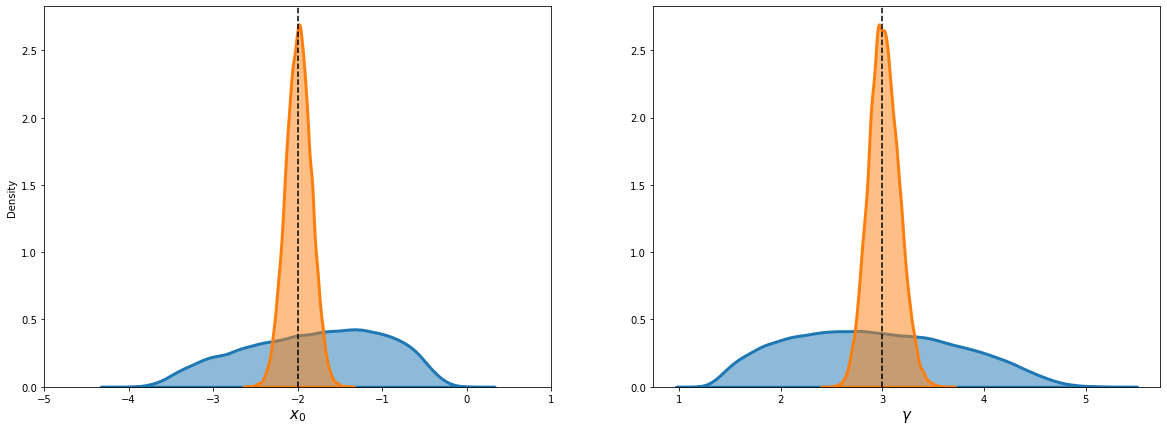

In [27]:
epsilon=abc["Dist"].iloc[T]
print("ABC epsilon =",epsilon)

f,ax=plt.subplots(1,2,figsize=(20,7))

sns.kdeplot(abc["x_0"].iloc[:T],label="ABC",ax=ax[0],fill=True,alpha=0.5,lw=3)
sns.kdeplot(Gibbs["chains"]["loc"],label="Gibbs",ax=ax[0],fill=True,alpha=0.5,lw=3)

x=np.linspace(np.min(abc["x_0"].iloc[:T]),np.max(abc["x_0"].iloc[:T]),1000)
ax[0].axvline(x=true_x_0,color="black",label="True value",linestyle="--")
ax[0].set_xlabel("$x_0$",fontsize=15)
ax[0].set_xlim([true_x_0-true_gamma,true_x_0+true_gamma])

sns.kdeplot(abc["gamma"].iloc[:T],label="ABC",ax=ax[1],fill=True,alpha=0.5,lw=3)
sns.kdeplot(Gibbs["chains"]["scale"],label="Gibbs",ax=ax[1],fill=True,alpha=0.5,lw=3)

x=np.linspace(np.min(abc["gamma"].iloc[:T]),np.max(abc["gamma"].iloc[:T]),1000)
ax[1].axvline(x=true_gamma,color="black",label="True value",linestyle="--")
ax[1].set_xlabel("$\gamma$",fontsize=15)
ax[1].set_ylabel("",fontsize=15)

plt.savefig("figure_5.png")
#plt.legend()